In [3]:
import pandas as pd
import numpy as np
from scipy.stats import norm, mannwhitneyu
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

Загружаем данные и удаляем лишнюю колонку

In [4]:
df = pd.read_csv('hw_bootstrap.csv', sep=';')
df.drop(columns=['Unnamed: 0'], inplace=True)
df

,value,experimentVariant
0,"10,3804953740268",Control
1,"9,54686666784264",Control
2,"11,0882146509904",Control
3,"10,1472740570122",Control
4,"9,78980767524929",Control
...,...,...
995,1000,Treatment
996,1200,Treatment
997,1500,Treatment
998,2000,Treatment


Смотрим на типы колонок и количество пропущенных значений

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   value              1000 non-null   object
 1   experimentVariant  1000 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB


В данных нет пропущенных значений, однако предполагаемый числовой формат представлен как object. Это случилось из-за использования знака "," вместо ".". Изменим это и приведем к тиму float64.

In [6]:
df['value'] = df['value'].apply(lambda x: x.replace(',', '.'))
df['value'] = pd.to_numeric(df['value'])
df.dtypes

value                float64
experimentVariant     object
dtype: object

Разделим наборы на тестовую и контрольную выборки

In [7]:
df_test = df.query('experimentVariant == "Treatment"') \
                 .drop(columns=['experimentVariant']) \
                 .reset_index(drop=True)
df_test

,value
0,10.380495
1,9.546867
2,11.088215
3,10.147274
4,9.789808
...,...
495,1000.000000
496,1200.000000
497,1500.000000
498,2000.000000


In [8]:
df_control = df.query('experimentVariant == "Control"') \
                 .drop(columns=['experimentVariant']) \
                 .reset_index(drop=True)
df_control

,value
0,10.380495
1,9.546867
2,11.088215
3,10.147274
4,9.789808
...,...
495,10.973929
496,10.261074
497,8.780090
498,11.169078


Рассмотрим распределения в этих группах

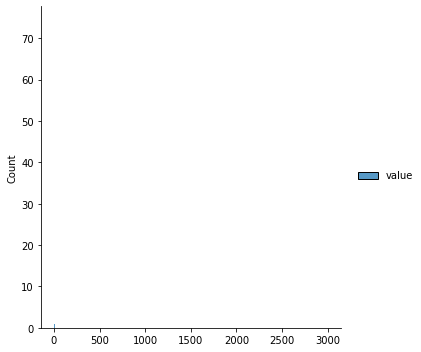

In [9]:
sns.displot(df_test)

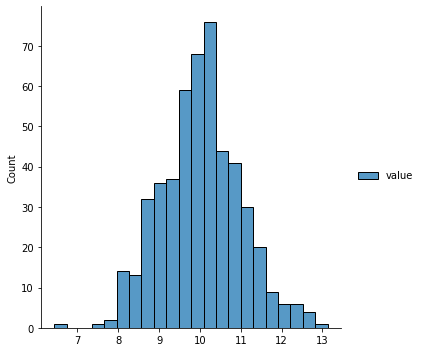

In [10]:
sns.displot(df_control)

Распределение для тестовой группы выглядит не совсем адекватно, рассмотрим подробнее эти группы с помощью метода `describe`

In [11]:
df_test.describe()

,value
count,500.000000
mean,27.321499
std,186.557011
min,6.436541
25%,9.421968
50%,10.025847
75%,10.675721
max,3000.000000


In [12]:
df_control.describe()

,value
count,500.000000
mean,10.026867
std,0.979377
min,6.436541
25%,9.411024
50%,10.018465
75%,10.664879
max,13.130346


Минимальные значения в этих группах одинаковы, значения квантилей похожи, а среднее и стандартное отклонения очень сильно различаются.

В контрольной группе максимальное значение 13, попробуем отсеять в тестовой группе большие значения по значению в 100

In [13]:
df_test.query('value < 100')

,value
0,10.380495
1,9.546867
2,11.088215
3,10.147274
4,9.789808
...,...
490,10.916229
491,11.160869
492,8.202518
493,9.782199


In [14]:
df_test.query('value >= 100')

,value
495,1000.0
496,1200.0
497,1500.0
498,2000.0
499,3000.0


Пять значений в тестовой группе стали слишком большими. Сравним распределения для тестовой (без учета таких сильных изменений) и контрольной групп

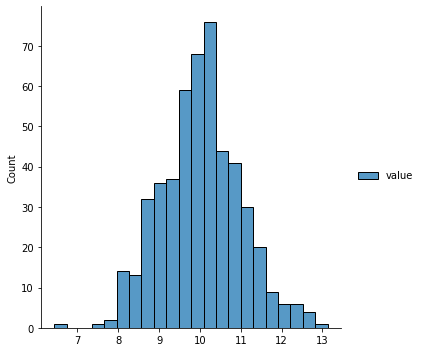

In [15]:
sns.displot(df_control)

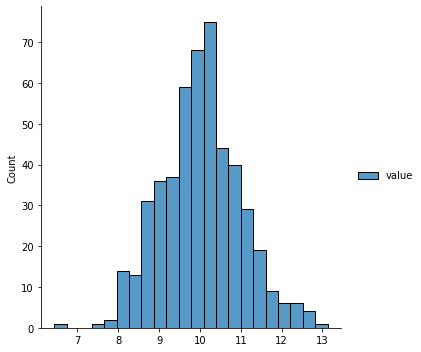

In [16]:
sns.displot(df_test.query('value < 100'))

"На глаз" распределения одинаковые, ещё раз посмотрим на значения в наборах

In [17]:
df_test.query('value < 100').head()

,value
0,10.380495
1,9.546867
2,11.088215
3,10.147274
4,9.789808


In [18]:
df_control.head()

,value
0,10.380495
1,9.546867
2,11.088215
3,10.147274
4,9.789808


In [19]:
df_test.query('value < 100').tail()

,value
490,10.916229
491,11.160869
492,8.202518
493,9.782199
494,10.484967


In [20]:
df_control.tail()

,value
495,10.973929
496,10.261074
497,8.780090
498,11.169078
499,11.499566


Первые 5 значений в этих группах одинаковы, однако последние 5 различны. Это связано с тем, что в этих группах неодинаковое количество элементов. Сравним значения первых 495 наблюдений в обеих группах

In [21]:
(df_control.loc[:'494'].sort_values('value') == df_test.query('value < 100').sort_values('value')).sum()

value    495
dtype: int64

Все значения в этих группах одинаковы, однако для последних 5 значений произошли сильные изменения.

**Но вернемся все же к заданию**

В самом начале используем рассматриваемую в лекции функцию

Рассчитаем p-value с помощью критерия Манна-Уитни

In [25]:
mannwhitneyu(df_control, df_test)

MannwhitneyuResult(statistic=124189.5, pvalue=0.42960742912427896)

В результате проведенного теста можно сказать, что значимых различий в распределениях обнаружить не удалось. Однако, на основе проводимых ранее исследований можно сделать вывод, что изменению подверглись последние 5 значений. Проведем u-тест для контрольной группы и подвыборкой, где `value >= 100`

In [26]:
mannwhitneyu(df_control, df_test.query('value >= 100'))

MannwhitneyuResult(statistic=0.0, pvalue=5.944286400360133e-05)

Теперь можно говорить о наличии значимых различий между этими группами.

Применим бутстрап с np.mean и посмотрим на распределение средних, доверительный интервал и p-value

In [27]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

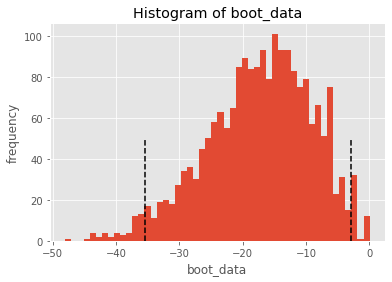

In [30]:
booted_data = get_bootstrap(df_control, df_test, boot_it = 2000, statistic = np.mean)

In [31]:
booted_data['p_value']

0.03698767812536667

В данном распределение 0 не включен в доверительный интервал, а p-value меньше 0.05 (0.037), что может говорить о получении значимых различий распределения средних значений в группах. Однако, все-таки полученное значение очень близко к пороговому в 0.05, и для принятия решений нужно больше наблюдений

Применим бутстрап и рассмотрим, есть ли значимые различия в распределении медианных значений

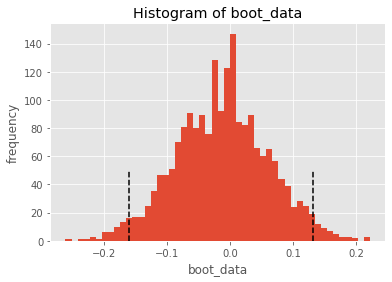

In [32]:
booted_data = get_bootstrap(df_control, df_test, boot_it = 2000, statistic = np.median)

In [33]:
booted_data['p_value']

0.8677378800830449

При использовании бутстрапа с np.median центр распределения находится в нуле, а p-value намного больше 0.05 (0.894), что может говорить об отсутствии значимых различий медианных значений между группами. Это может объясняться тем фактом, что медиана довольно хорошо работает при наличии небольшого количества аномально больших значений (выбросов) в наборе

В результате проведенных экспериментов можно сделать следующие выводы:
1. Тестовая выборка имеет большие выбросы, что сильно искажает нам среднее значение
2. Применяя бутстрап с оценкой среднего, мы могли бы отклонить нулевую гипотезу о равенстве средних и сделать вывод, что тестовая и контрольная выборка имеют различия
3. Однако, тот же бутстрап, но уже по медиане не дает нам отклонить нулевую гипотезу, так как p-value сильно больше 0.05, т.к. здесь проверяется другая гипотеза
4. U-критерий Манна-Уитни так же не дал бы нам отклонить нулевую гипотезу.